In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import PromptTemplate

from IPython.display import Image, display

from gigachat import GigaChat
from gigachat.models import Chat, Messages, MessagesRole

from ddgs import DDGS

import requests
import trafilatura

import os

from dotenv import load_dotenv

from typing import List, Dict, Tuple, Literal, Annotated, Any, Optional
from typing_extensions import TypedDict

from operator import add

In [2]:
load_dotenv('env')

True

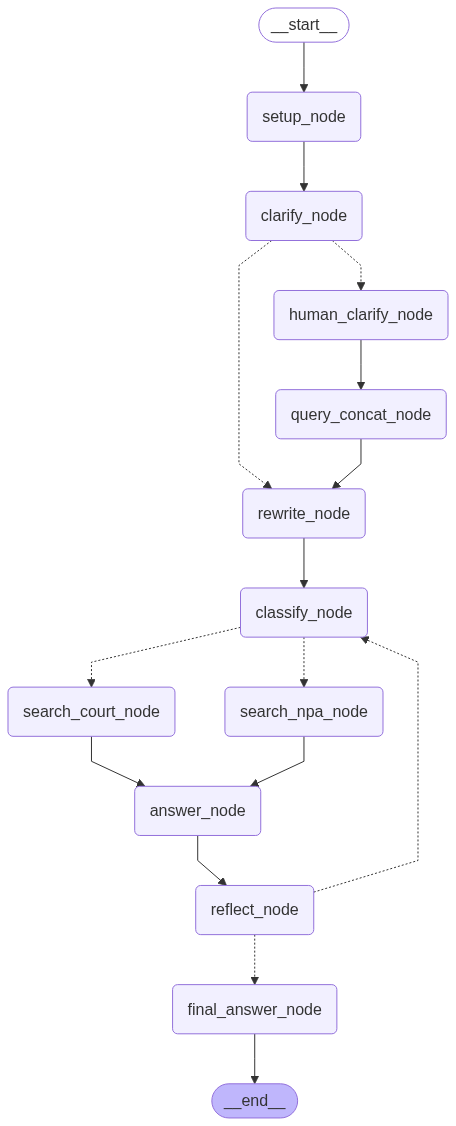

In [3]:
with open('../graph.png', 'rb') as fd:
    display(Image(fd.read()))

In [4]:
gigachat_token = os.environ['GIGACHAT_API_KEY']

In [5]:
llm = GigaChat(credentials=gigachat_token, verify_ssl_certs=False, scope='GIGACHAT_API_CORP')

In [6]:
dict(llm.get_models())

{'x_headers': {'x-request-id': '357887d1-dac2-4dfd-b4ac-984bb733556d',
  'x-session-id': '538afa81-5721-4423-8941-a6c538ce088b',
  'x-client-id': None},
 'data': [Model(x_headers=None, id_='GigaChat', object_='model', owned_by='salutedevices'),
  Model(x_headers=None, id_='GigaChat-2', object_='model', owned_by='salutedevices'),
  Model(x_headers=None, id_='GigaChat-2-Max', object_='model', owned_by='salutedevices'),
  Model(x_headers=None, id_='GigaChat-2-Max-preview', object_='model', owned_by='salutedevices'),
  Model(x_headers=None, id_='GigaChat-2-Pro', object_='model', owned_by='salutedevices'),
  Model(x_headers=None, id_='GigaChat-2-Pro-preview', object_='model', owned_by='salutedevices'),
  Model(x_headers=None, id_='GigaChat-2-preview', object_='model', owned_by='salutedevices'),
  Model(x_headers=None, id_='GigaChat-Max', object_='model', owned_by='salutedevices'),
  Model(x_headers=None, id_='GigaChat-Max-preview', object_='model', owned_by='salutedevices'),
  Model(x_heade

In [7]:
def ask_giga(query: str, model: str):
    payload = Chat(
        messages=[
            Messages(
                role=MessagesRole.USER,
                content=query
            )
        ],
        temperature=1.0,
        max_tokens=1000,
        top_p=0.0,
        repetition_penalty=1.0,
        model=model
    )
    response = llm.chat(payload)
    return response.dict()['choices'][0]['message']['content'].strip()

In [8]:
ask_giga('Привет, ты кто?', 'GigaChat-2')

'Привет! Я GigaChat — нейросетевая модель, созданная компанией Sber в России. Могу помочь с разными задачами: от обсуждения интересных тем до решения сложных вопросов. Расскажи, что тебя интересует!'

In [9]:
def ddgs_search(query: str, max_results: int=3):
    results = DDGS().text(query, max_results=max_results)
    for r in results:
        try:
            doc_html = trafilatura.fetch_url(r['href'])
            doc_text = trafilatura.extract(doc_html)
            r['doc_html'] = doc_html
            r['doc_text'] = doc_text
        except Exception as e:
            print(f"Ошибка при извлечении текста с {r['href']}: {e}")
            r['doc_html'] = ""
            r['doc_text'] = ""
    return results

In [15]:
res = ddgs_search('как обжаловать штраф?')

In [16]:
res[0].keys()

dict_keys(['title', 'href', 'body', 'doc_html', 'doc_text'])

In [17]:
res[0]['title']

'Как обжаловать штраф ГИБДД, МАДИ, АМПП, как оспорить ...'

In [18]:
res[0]['href']

'https://www.mos.ru/otvet-transport/kak-osporit-avtomobilnye-shtrafy/'

In [19]:
print(res[0]['doc_text'][:2000])

Как оспорить автомобильные штрафы
Как оспорить штраф за неправильную парковку или другое нарушение ПДД. В течение какого времени можно оспорить штраф. Как вернуть деньги за ошибочно оплаченный штраф
1. В течение какого времени можно оспорить штраф?
Обжаловать штраф за нарушение правил дорожного движения (ПДД) можно в течение 10 дней с того момента, как вы получите копию постановления об административном правонарушении. Если вы подадите жалобу в установленный законом срок, постановление не вступит в законную силу. Если по каким-либо причинам вы пропустили отведенное время, придется дополнительно приложить к жалобе письмо — ходатайство о восстановлении пропущенного срока обжалования постановления. Если ходатайство удовлетворят, срок подачи жалобы будет продлен.
Подавать жалобу нужно в то ведомство, которое выписало постановление: Московскую административную дорожную инспекцию (МАДИ), ГКУ «Администратор московского парковочного пространства» (АМПП) или ГИБДД. Обратите внимание, если жалоб

In [20]:
def call_npa_api(query: str):
    query = query + ' site:consultant.ru/'
    results = ddgs_search(query)
    return results

In [21]:
def call_court_api(query: str):
    # query = query + ' site:судебныерешения.рф'
    # query = query + ' site:sudrf.ru'
    query = query + ' site:reputation.su'
    results = ddgs_search(query)
    return results

In [27]:
res = call_court_api('как обжаловать штраф')

In [28]:
res[0].keys()

dict_keys(['title', 'href', 'body', 'doc_html', 'doc_text'])

In [29]:
res[-1]['href']

'https://reputation.su/sudrf/220322406'

In [30]:
def format_docs(search_results: List[Dict]):
    tpl = ''
    for i, r in enumerate(search_results):
        # Используем get с дефолтными значениями на случай, если ключи отсутствуют
        title = r.get('title', '')
        doc_text = r.get('doc_text', '')[:15000] # Ограничиваем длину
        tpl += f"[Source {i}]: {title}\n{doc_text}\n\n" # Добавим пустую строку для разделения
    return tpl

In [31]:
print(format_docs(res))

[Source 0]: Судебный акт #1 (Решение) по делу № 2-272/2021 (2-4583/2020 ...
Дело №2-272/2021 (2-4583/2020) 19 февраля 2021 года
РЕШЕНИЕ
ИМЕНЕМ РОССИЙСКОЙ ФЕДЕРАЦИИ
Красносельский районный суд Санкт-Петербурга в составе:
председательствующего судьи Щетникова П.С.
при секретаре Килиной А.И.,
рассмотрев в открытом судебном заседании гражданское дело по иску Аникеева Александра Олеговича к Захаровой Екатерине Андреевне о взыскании задолженности по договору займа, судебных расходов и упущенной выгоды,
установил:
Аникеев А.О., уточнив в порядке статьи 39 ГПК РФ свои требования, обратился в Красносельский районный суд Санкт-Петербурга с иском к Захаровой Е.А., в котором просит взыскать: задолженность по договору займа 720000 рублей, проценты за пользование займом по состоянию на 19 февраля 2021 года в размере 47183 рублей 60 копеек, проценты за период с 19 февраля 2021 года по день фактического исполнения обязательства, исчисленные от неуплаченной суммы долга, исходя из 6,5% годовых, штраф за

In [32]:
def format_links(search_results):
    links = []
    for r in search_results:
        links.append(f"{r['title']} [{r['href']}\n\n")
    return '\n'.join(links)

In [33]:
print(format_links(res))

Судебный акт #1 (Решение) по делу № 2-272/2021 (2-4583/2020 ... [https://reputation.su/sudrf/227819444


Решение по делу № 5-72/2023 от 27.01.2023 [https://reputation.su/sudrf/230837143


Судебный акт #1 (Решение) по делу № 12-255/2023 от 02.11.2023 [https://reputation.su/sudrf/220322406




In [34]:
def ask_human(query: str):
    return input(query)

In [35]:
ask_human('Кто убил Кеннеди?')

Кто убил Кеннеди? Ли Освальд


'Ли Освальд'

In [36]:
def format_dialog(messages: List[Tuple[str, str]]): # Уточнение типа
    tpl = ''
    for m in messages:
        tpl += f"[{m[0]}]: {m[1]}\n\n" # Добавим перевод строки
    return tpl

In [45]:
# Промпты
clarification_prompt = PromptTemplate.from_template("""Ты юридический ассистент в Российской Федерации. Тебе дан вопрос пользователя.
Твоя задача определить, надо ли что-то уточнить у пользователя, чтобы выполнить юридический поиск или вопрос пользователя содержит всю необходимую информацию?
Если вопрос содержит всю необходимую информацию ответь: "ок" и больше ничего не пиши.  
Пример: 
Вопрос пользователя: "мне не заплатили по договору, в какой суд подать иск?"
Ответ: Уточите пожалуйста, вы являетесь физическим лицом, индивидуальным предпринимателем или описываете ситуацию компании (юридического лица)?
Вопрос пользователя: "Какой вычет НДФЛ на первого ребенка"
Ответ: ок
[Вопрос пользователя]: "{query}"
Не отвечай на вопрос пользователя, не продолжай диалог, выполни свою задачу.""")

query_concat_prompt = PromptTemplate.from_template("""Ты юридический ассистент. Тебе дан диалог с пользователем, твоя задача собрать этот диалог в один вопрос к справочной правовой системе, который учтет всю информацию, полученную от пользователя.
<dialog>
{dialog}
</dialog>
Не продолжай диалог, только сформулируй один вопрос.
Вопрос к поисковой системе:""")

query_rewrite_prompt = PromptTemplate.from_template("""Ты юридический ассистент. Преобразуй запрос пользователя в краткую, точную поисковую фразу, подходящую для ввода в правовую систему (например, «КонсультантПлюс», «Гарант»).
Требования к результату:
- Сохраняй юридический смысл исходного запроса.
- Используй официальную юридическую терминологию.
- Убирай разговорные формулировки, местоимения и лишние слова.
- Формулируй максимально ёмко — как если бы ты искал в базе законов или судебных решений.
- Не добавляй пояснений, комментариев или примеров.
- Отвечай только одной строкой — самой поисковой фразой.

Примеры преобразований:
Исходный запрос: "Что будет, если не платить алименты?"
Поисковая фраза: Уклонение от уплаты алиментов ответственность
Исходный запрос: "Могу ли я вернуть товар, если он не подошёл по цвету?"
Поисковая фраза: Возврат товара ненадлежащего качества цвет
Исходный запрос: "Какие льготы у ветеранов труда в Москве?"
Поисковая фраза: Льготы ветеранам труда Москва
Исходный запрос: "Судебная практика по увольнению за прогул без объяснений"
Поисковая фраза: Судебная практика увольнение за прогул отсутствие объяснений
Исходный запрос: "Что говорит 217-ФЗ о добровольной ликвидации ООО?"
Поисковая фраза: ФЗ-217 добровольная ликвидация ООО

Теперь обработай следующий запрос (не отвечая на сам вопрос, только сделай перефразировку):
[Исходный запрос]: "{query}"
Поисковая фраза:""")

classification_prompt = PromptTemplate.from_template("""Ты юридический ассистент. Проанализируй следующий запрос пользователя и определи, к какой категории он относится:
- "НПА" — если запрос касается нормативно-правовых актов: законов, кодексов, статей, постановлений, правил, положений, требований законодательства, юридических норм, обязанностей по закону и т.п.
- "Судебное" — если запрос касается судебных решений, прецедентов, примеров из практики судов, разборов дел, аргументов в суде, толкования норм судами, позиции ВС/Арбитражных судов и т.п.
Важно: отвечай **только одним словом** — либо "НПА", либо "Судебное".
Запрос: "{query}"
Ответ (одно слово):""")

rag_prompt = PromptTemplate.from_template("""Ты — опытный юрист. На основе представленных документов ответь на вопрос пользователя, строго придерживаясь следующей структуры:
1. **Законодательство**
   Перечисли применимые нормативно-правовые акты, статьи, положения. Укажи, что именно они устанавливают по вопросу. Ссылайся только на документы, приведённые ниже. Не добавляй внешние знания.
2. **Судебная практика**
   Приведи примеры из судебных решений, если они есть в документах. Укажи: какой суд, по какому делу, какую позицию занял. Если практики нет — напиши: "В представленных документах отсутствует судебная практика по данному вопросу."
3. **Вывод**  
   Дай краткий, однозначный ответ на вопрос, основанный на совокупности НПА и судебной практики. Формулируй как юридическую позицию: что допускается, запрещено, рекомендовано, возможно в суде и т.п.
Требования:
- Отвечай только на основе документов.
- Не вымышляй нормы или дела.
- Используй официальную юридическую терминологию.
- Будь точен, лаконичен, структурирован.
[Вопрос]: "{query}"
[Документы]:
{docs}
Ответ:""")

reflection_prompt = PromptTemplate.from_template("""Ты — эксперт-юрист. Проанализируй вопрос пользователя и черновик ответа. 
Оцени, насколько черновик ответа полностью раскрывает вопрос с точки зрения:
- нормативно-правового регулирования (НПА),
- судебной практики (если уместно),
- возможных нюансов, условий, исключений.
Если ответ:
- полностью раскрывает вопрос по всем значимым аспектам → верни одну фразу: "ок" и больше ничего не пиши.
- недостаточен, содержит пробелы или требует уточнения → сформулируй один точный поисковой запрос для справочно-правовой системы (например, «КонсультантПлюс», «Гарант»), который поможет дополнить ответ. Запрос должен быть кратким, ёмким, с использованием юридической терминологии.
Не добавляй пояснений. Отвечай только "ок" или поисковой фразой.
---
Пример 1:
Вопрос: Можно ли уволить сотрудника за однократный прогул без предупреждений?
Черновик ответа: Да, можно. Согласно ст. 81 ТК РФ, прогул является основанием для увольнения.
Твой ответ: Судебная практика увольнение за прогул отсутствие уведомления
Пример 2:
Вопрос: Облагается ли НДС продажа доли в уставном капитале ООО?
Черновик ответа: Нет, передача доли в уставном капитале ООО не облагается НДС на основании п. 2 ст. 149 НК РФ.
Твой ответ: ок
---
[Вопрос]: "{query}"
[Черновик ответа]: {response}
[Твой ответ]:""")

final_answer_prompt = PromptTemplate.from_template("""Ты — опытный юрист. На основе представленных документов ответь на вопрос пользователя, строго придерживаясь следующей структуры:
1. **Законодательство**
   Перечисли применимые нормативно-правовые акты, статьи, положения. Укажи, что именно они устанавливают по вопросу. Ссылайся только на документы, приведённые ниже. Не добавляй внешние знания.
2. **Судебная практика**
   Приведи примеры из судебных решений, если они есть в документах. Укажи: какой суд, по какому делу, какую позицию занял. Если практики нет — напиши: "В представленных документах отсутствует судебная практика по данному вопросу."
3. **Вывод**  
    Дай развернутый ответ на основе всех предложенных документов. Формулируй как юридическую позицию: что допускается, запрещено, рекомендовано, возможно в суде и т.п.

Требования:
- Отвечай только на основе документов.
- Не вымышляй нормы или дела.
- Используй официальную юридическую терминологию.
- Будь точен, лаконичен, структурирован.
[Вопрос]: "{query}"
[Документы]:
{docs}
Ответ:""")

In [46]:
class MyState(TypedDict):
    # Используем Optional для полей, которые могут отсутствовать в начале
    query: str  # Исходный запрос пользователя
    search_query: Optional[str] # Текущий поисковый запрос агента
    messages: Annotated[List[Tuple[str, str]], add]  # Сообщения
    clarification: Optional[str]
    need_clarify_question: Optional[bool]
    category: Optional[str]
    docs: Annotated[List[Dict], add] # Документы, полученные в результате поиска
    answers: Annotated[List[Any], add] # Промежуточные ответы ассистента
    final_answer: str
    need_re_search: Optional[bool]
    re_search_cnt: Optional[int]
    clarification_cnt: Optional[int]
    verbose: Optional[bool]

In [47]:
# Nodes
def setup_node(state: MyState) -> MyState:
    state_update = dict()
    state_update['search_query'] = state['query']
    state_update['messages'] = [('user', state['query'])]
    state_update['clarification'] = None
    state_update['need_clarify_question'] = None
    state_update['category'] = None
    state_update['docs'] = []
    state_update['answers'] = []
    state_update['final_answer'] = None
    state_update['need_re_search'] = None
    state_update['re_search_cnt'] = 0
    state_update['clarification_cnt'] = 0
    state_update['verbose'] = state.get('verbose', False)
    
    return state_update
    
def clarify_node(state: MyState) -> MyState:
    """
    Проверяем нуждается ли вопрос в уточнении от пользователя.
    Если нуждается, то формулируем уточняющий вопрос
    """
    query = state["search_query"]
    prompt = clarification_prompt.format(query=query)
    gen = ask_giga(prompt, 'GigaChat-2')

    state_update = dict()
    state_update["need_clarify_question"] = False if (len(gen) < 10 and 'ок' in gen.lower()) else True
    state_update['messages'] = [('tool_clarify', gen)]
    state_update['clarification'] = gen
    state_update['clarification_cnt'] = state['clarification_cnt'] + 1
    
    if state['verbose']:
        print("clarify_node:", gen)
    
    return state_update


def human_clarify_node(state: MyState) -> MyState:
    """Просим пользователя ответить на уточняющий вопрос"""
    value = ask_human(state['clarification'])
    
    message = ('user', value)
    
    state_update = dict()
    state_update['messages'] = [message]

    if state['verbose']:
        print("human_clarify_node:", value)
    
    return state_update

    
def query_concat_node(state: MyState) -> MyState:
    """Объединяем диалог с пользователем в один вопрос для поиска"""
    dialog = format_dialog(state['messages'])
    prompt = query_concat_prompt.format(dialog=dialog)
    gen = ask_giga(prompt, 'GigaChat-2')

    message = ('tool_concat', gen)
    
    state_update = dict()
    state_update['search_query'] = gen
    state_update['messages'] = [message]

    if state['verbose']:
        print("query_concat_node:", gen)
    
    return state_update

    
def rewrite_node(state: MyState) -> MyState:
    query = state["search_query"]
    prompt = query_rewrite_prompt.format(query=query)
    rewritten = ask_giga(prompt, 'GigaChat-2')

    message = ('tool_rewrite', rewritten)
    
    state_update = dict()
    state_update["search_query"] = rewritten
    state_update['messages'] = [message]

    if state['verbose']:
        print("rewrite_node:", message)
        
    return state_update


def classify_node(state: MyState) -> MyState:
    """Классифицируем запрос по типу поиск - в правовой системе или в судебной практике"""
    query = state["search_query"]
    prompt = classification_prompt.format(query=query)
    category = ask_giga(prompt, 'GigaChat-2')

    message = ('tool_classify', category)
    
    state_update = dict()
    state_update["category"] = category
    state_update['messages'] = [message]
    state_update['docs'] = []
    
    if state['verbose']:
        print("classify_node:", category)
    
    return state_update


def search_npa_node(state: MyState) -> MyState:
    results = call_npa_api(state["search_query"])

    message_text = format_links(results)
    message = ('result_search_npa', message_text)
    
    state_update = dict()
    state_update["docs"] = results
    state_update['messages'] = [message]

    if state['verbose']:
        print("search_npa_node:", message_text)
    
    return state_update


def search_court_node(state: MyState) -> MyState:
    results = call_court_api(state["search_query"])

    message_text = format_links(results)
    message = ('result_search_court', message_text)
    
    state_update = dict()
    state_update["docs"] = results
    state_update['messages'] = [message]

    if state['verbose']:
        print("search_court_node:", message_text)
    
    return state_update


def answer_node(state: MyState) -> MyState:
    query=state["search_query"]
    # Проверка на существование docs
    docs = state.get("docs", [])
    if not docs:
        # Обработка случая, если документы не найдены
        answer = "Извините, по вашему запросу не удалось найти подходящие документы."
    else:
        prompt = rag_prompt.format(query=query, docs=format_docs(docs))
        answer = ask_giga(prompt, 'GigaChat-2')
    
    answer_data = {
        'title': query,
        'doc_text': answer
    }
    
    message = ('tool_rag', answer)

    state_update = dict()
    state_update["answers"] = [answer_data]
    state_update['messages'] = [message]
    
    if state['verbose']:
        print("answer_node:", answer)
    
    return state_update


def reflect_node(state: MyState) -> MyState:
    answer = state['answers'][-1]
    prompt = reflection_prompt.format(query=state["search_query"], response=answer)
    gen = ask_giga(prompt, 'GigaChat-2')

    message = ('tool_reflect', gen)

    state_update = dict()
    state_update["need_re_search"] = False if (len(gen) < 10 and 'ок' in gen.lower()) else True
    if state_update["need_re_search"]:
        state_update["search_query"] = gen
    
    state_update['messages'] = [message]
    state_update['re_search_cnt'] = state['re_search_cnt'] + 1

    if state['verbose']:
        print("reflect_node:", gen)
    
    return state_update


def final_answer_node(state: MyState) -> MyState:
    query=state["query"]
    # Проверка на существование docs
    docs = state["answers"]
    if not docs:
        # Обработка случая, если документы не найдены
        answer = "Извините, по вашему запросу не удалось найти подходящие документы."
    elif len(docs) == 1:
        answer = docs[0]["doc_text"]
    else:
        prompt = final_answer_prompt.format(query=query, docs=format_docs(docs))
        answer = ask_giga(prompt, 'GigaChat-2')

    message = ('tool_final_answer', answer)
    
    state_update = dict()
    state_update['final_answer'] = answer
    state_update['messages'] = [message]

    if state['verbose']:
        print("answer_node:", answer)
    
    return state_update
    

In [48]:
# Decisions
def check_need_human(state: MyState) -> Literal['human_clarify_node', 'rewrite_node']:
    clarification_cnt = state['clarification_cnt']
    need_clarify_question = state['need_clarify_question']

    if clarification_cnt > 1:
        return 'rewrite_node'
    if need_clarify_question:
        return 'human_clarify_node'
    return 'rewrite_node'


def check_search_type(state: MyState) -> Literal['search_npa_node', 'search_court_node']:
    # Проверка существования ключа
    category = state['category'].lower()
    if 'нпа' in category:
        return 'search_npa_node'
    if 'суд' in category:
        return 'search_court_node'
    return 'search_npa_node'  # По умолчанию ищем в НПА


def check_need_re_search(state: MyState) -> Literal['classify_node', 'final_answer_node']:
    # Проверка существования ключей
    re_search_cnt = state['re_search_cnt']
    need_re_search_flag = state['need_re_search']

    if re_search_cnt > 1:
        return 'final_answer_node'
    if need_re_search_flag:
        return 'classify_node' # После рефлексии снова классифицируем вопрос и идем в поиск
    return 'final_answer_node'

In [49]:
# Workflow definition
workflow = StateGraph(MyState)
workflow.add_node("setup_node", setup_node)
workflow.add_node("clarify_node", clarify_node)
workflow.add_node("human_clarify_node", human_clarify_node)
workflow.add_node("query_concat_node", query_concat_node)
workflow.add_node("rewrite_node", rewrite_node)
workflow.add_node("classify_node", classify_node)
workflow.add_node("search_npa_node", search_npa_node)
workflow.add_node("search_court_node", search_court_node)
workflow.add_node("answer_node", answer_node)
workflow.add_node("reflect_node", reflect_node)
workflow.add_node("final_answer_node", final_answer_node)


workflow.add_edge(START, "setup_node")
workflow.add_edge("setup_node", "clarify_node")
workflow.add_conditional_edges("clarify_node", check_need_human)
workflow.add_edge("human_clarify_node", "query_concat_node")
workflow.add_edge("query_concat_node", "rewrite_node")
workflow.add_edge("rewrite_node", "classify_node")
workflow.add_conditional_edges("classify_node", check_search_type)
workflow.add_edge("search_npa_node", "answer_node")
workflow.add_edge("search_court_node", "answer_node")
workflow.add_edge("answer_node", "reflect_node")
workflow.add_conditional_edges("reflect_node", check_need_re_search)
workflow.add_edge("final_answer_node", END)

# Компиляция графа
graph = workflow.compile()

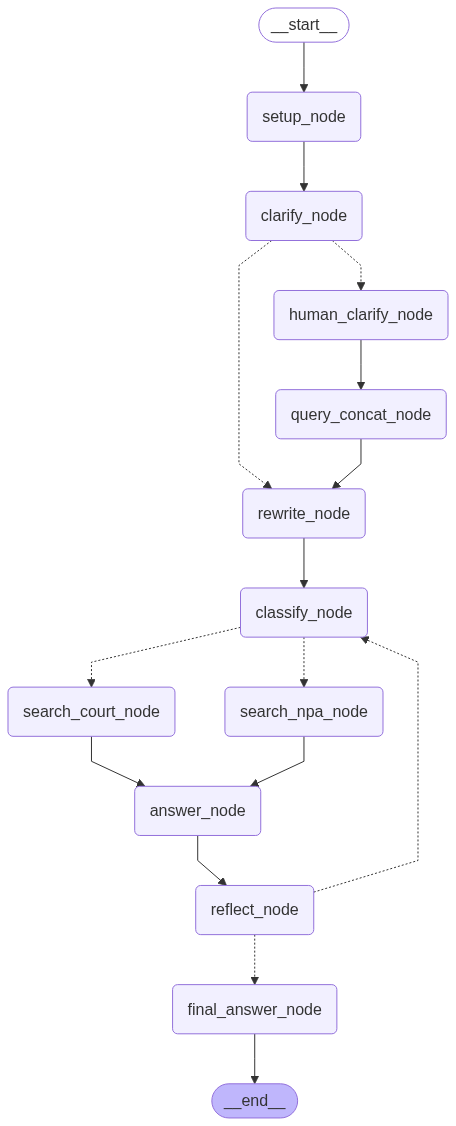

In [50]:
graph

In [43]:
with open('../graph.png', 'wb') as fd:
    fd.write(Image(graph.get_graph().draw_mermaid_png()).data)

In [51]:
state = dict()
state['query'] = 'Как обжаловать расторжение договора аренды?'

# stream(from_checkpoint=None) означает запуск с самого начала
# stream_mode="values" тоже может быть полезен
for step_result in graph.stream(state, stream_mode="updates"):
    print("--- ШАГ ---")
    # step_result - это словарь, где ключ - это имя узла или "__end__", а значение - обновленное состояние (state)
    for node_name, updated_state in step_result.items():
        print(f"Выполнен узел: {node_name}")
        # Здесь вы можете инспектировать updated_state
        print(f"  Текущий search_query: {updated_state.get('search_query', 'N/A')}")
        print(f"  Текущая category: {updated_state.get('category', 'N/A')}")
        print(f"  Текущий answer: {updated_state.get('answer', 'N/A')[:100]}...") # Первые 100 символов
        print(f"  need_clarify_question: {updated_state.get('need_clarify_question', 'N/A')}")
        print(f"  need_re_search: {updated_state.get('need_re_search', 'N/A')}")
        print(f"  clarification_cnt: {updated_state.get('clarification_cnt', 'N/A')}")
        print(f"  re_search_cnt: {updated_state.get('re_search_cnt', 'N/A')}")
        # Печать последних нескольких сообщений для понимания диалога
        messages = updated_state.get('messages', [])
        if messages:
            print("  Последние сообщения:")
            for msg in messages[-3:]: # Печатаем последние 3 сообщения
                print(f"    {msg}")
        print("-" * 20)

--- ШАГ ---
Выполнен узел: setup_node
  Текущий search_query: Как обжаловать расторжение договора аренды?
  Текущая category: None
  Текущий answer: N/A...
  need_clarify_question: None
  need_re_search: None
  clarification_cnt: 0
  re_search_cnt: 0
  Последние сообщения:
    ('user', 'Как обжаловать расторжение договора аренды?')
--------------------
--- ШАГ ---
Выполнен узел: clarify_node
  Текущий search_query: N/A
  Текущая category: N/A
  Текущий answer: N/A...
  need_clarify_question: True
  need_re_search: N/A
  clarification_cnt: 1
  re_search_cnt: N/A
  Последние сообщения:
    ('tool_clarify', 'Уточните, пожалуйста, являетесь ли вы арендатором или арендодателем, и какие основания указаны в расторжении договора аренды?')
--------------------


Уточните, пожалуйста, являетесь ли вы арендатором или арендодателем, и какие основания указаны в расторжении договора аренды? я арендатор, основания не указали в уведомлении


--- ШАГ ---
Выполнен узел: human_clarify_node
  Текущий search_query: N/A
  Текущая category: N/A
  Текущий answer: N/A...
  need_clarify_question: N/A
  need_re_search: N/A
  clarification_cnt: N/A
  re_search_cnt: N/A
  Последние сообщения:
    ('user', 'я арендатор, основания не указали в уведомлении')
--------------------
--- ШАГ ---
Выполнен узел: query_concat_node
  Текущий search_query: Как арендатору обжаловать расторжение договора аренды без указания конкретных оснований в уведомлении?
  Текущая category: N/A
  Текущий answer: N/A...
  need_clarify_question: N/A
  need_re_search: N/A
  clarification_cnt: N/A
  re_search_cnt: N/A
  Последние сообщения:
    ('tool_concat', 'Как арендатору обжаловать расторжение договора аренды без указания конкретных оснований в уведомлении?')
--------------------
--- ШАГ ---
Выполнен узел: rewrite_node
  Текущий search_query: Обжалование расторжение договора аренды отсутствие конкретных оснований уведомление арендатора
  Текущая category: N/A
 

In [52]:
print(updated_state['final_answer'])

## 1. Законодательство

- **Гражданский кодекс Российской Федерации (ГК РФ):**
  - Статья 450: устанавливает основания и порядок изменения и расторжения договора по соглашению сторон или по решению суда.
  - Статья 452: определяет порядок расторжения договора по требованию одной из сторон.
  - Статья 619: предусматривает основания досрочного расторжения договора аренды по требованию арендодателя.
  - Статья 620: перечисляет случаи досрочного расторжения договора аренды по инициативе арендатора.

- **Земельный кодекс Российской Федерации (ЗК РФ):**
  - Статья 42: устанавливает обязанности собственников земельных участков и лиц, владеющих ими, в том числе использование участка в соответствии с его целевым назначением.
  - Статья 46: предусматривает основания прекращения аренды земельного участка по инициативе арендодателя.

- **Гражданский процессуальный кодекс Российской Федерации (ГПК РФ):**
  - Статья 167: регулирует порядок рассмотрения дела в отсутствие стороны.
  - Статья 309: уста

In [53]:
state = dict()

# state['query'] = 'Какие есть ограничения на увольнение беременной сотрудницы?'
state['query'] = 'Как обжаловать расторжение договора аренды?'
state['verbose'] = True

In [54]:
res = graph.invoke(state)

clarify_node: Уточните, пожалуйста, является ли сторона по договору аренды арендодателем или арендатором, и по каким основаниям было произведено расторжение договора?


Уточните, пожалуйста, является ли сторона по договору аренды арендодателем или арендатором, и по каким основаниям было произведено расторжение договора? я лось


human_clarify_node: я лось
query_concat_node: Как арендатор (Лось) может обжаловать решение о расторжении договора аренды, если не указаны основания и статус стороны по договору?
rewrite_node: ('tool_rewrite', 'Обжалование расторжение договора аренды основания отсутствие арендатор статус стороны')
classify_node: Судебное
search_court_node: Решение по делу № 2-584/2024 от 12.04.2024 [https://reputation.su/sudrf/273161868


Решение по делу № 2-1411/2015 ~ М-1252/2015 от 22.10.2015 [https://reputation.su/sudrf/198579587


Судебный акт #1 (Решение) по делу № 2-28/2016 (2-2661/2015 ... [https://reputation.su/sudrf/196264789


answer_node: ## 1. Законодательство

- **Земельный кодекс Российской Федерации (ЗК РФ)**:
  - Статья 39.6: устанавливает случаи предоставления земельных участков в аренду без проведения торгов, в том числе однократно для завершения строительства объекта незавершенного строительства собственнику объекта незавершенного строительства.
  - Статья 22: устанавливает общие пр

In [55]:
print(res['final_answer'])

## 1. Законодательство

- **Земельный кодекс Российской Федерации (ЗК РФ)**:
  - Статья 39.6: устанавливает случаи предоставления земельных участков в аренду без проведения торгов, в том числе однократно для завершения строительства объекта незавершенного строительства собственнику объекта незавершенного строительства.
  - Статья 22: устанавливает общие правила предоставления земельных участков в аренду.
  - Статья 39.16: предусматривает отказ в предоставлении земельного участка без проведения торгов в случае, если на участке расположены здания, сооружения или объект незавершенного строительства, принадлежащие гражданам или юридическим лицам.

- **Гражданский кодекс Российской Федерации (ГК РФ)**:
  - Статья 621: устанавливает, что арендатор, надлежащим образом исполнявший свои обязанности, имеет преимущественное право на заключение договора аренды на новый срок.
  - Статья 614: устанавливает обязанность арендатора своевременно вносить арендную плату.

## 2. Судебная практика

В предст

In [56]:
len(res['messages'])

10

In [57]:
print(format_dialog(res['messages']))

[user]: Как обжаловать расторжение договора аренды?

[tool_clarify]: Уточните, пожалуйста, является ли сторона по договору аренды арендодателем или арендатором, и по каким основаниям было произведено расторжение договора?

[user]: я лось

[tool_concat]: Как арендатор (Лось) может обжаловать решение о расторжении договора аренды, если не указаны основания и статус стороны по договору?

[tool_rewrite]: Обжалование расторжение договора аренды основания отсутствие арендатор статус стороны

[tool_classify]: Судебное

[result_search_court]: Решение по делу № 2-584/2024 от 12.04.2024 [https://reputation.su/sudrf/273161868


Решение по делу № 2-1411/2015 ~ М-1252/2015 от 22.10.2015 [https://reputation.su/sudrf/198579587


Судебный акт #1 (Решение) по делу № 2-28/2016 (2-2661/2015 ... [https://reputation.su/sudrf/196264789



[tool_rag]: ## 1. Законодательство

- **Земельный кодекс Российской Федерации (ЗК РФ)**:
  - Статья 39.6: устанавливает случаи предоставления земельных участков в аренду б

In [58]:
res.keys()

dict_keys(['query', 'search_query', 'messages', 'clarification', 'need_clarify_question', 'category', 'docs', 'answers', 'final_answer', 'need_re_search', 're_search_cnt', 'clarification_cnt', 'verbose'])

In [59]:
res['clarification_cnt']

1

In [60]:
res['re_search_cnt']

1

In [61]:
res['need_re_search']

False

In [62]:
res['search_query']

'Обжалование расторжение договора аренды основания отсутствие арендатор статус стороны'

In [63]:
res['clarification']

'Уточните, пожалуйста, является ли сторона по договору аренды арендодателем или арендатором, и по каким основаниям было произведено расторжение договора?'

In [64]:
res['need_clarify_question']

True

In [65]:
res['category']

'Судебное'